In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

from boosting_helper import (
    generate_dataset,
    visualize_dataset,
    gb_suite, ab_suite,
    visualize_loss_curves_gb, visualize_loss_curves_ab,
    animate_gb, animate_ab
)

# importing cleaned data
train_data = pd.read_csv('https://raw.githubusercontent.com/jsunn-y/Caltech-CS155-2022/main/miniprojects/data/train_imputed_encoded.csv', index_col='id')
new_train1 = train_data.loc[train_data['loan_status'] == 1]

#adjust the amount of paid loan data to add
new_train2 = train_data.loc[train_data['loan_status'] == 0].sample(frac=0.35) #0.35 seems to work well
new_train_data = pd.concat([new_train1, new_train2])

y_train = new_train_data['loan_status'].values
y_train = y_train.reshape(-1,1)
X_train = new_train_data.drop(['loan_status'], axis=1)

input_dim = X_train.shape[1]

test_data = pd.read_csv('https://raw.githubusercontent.com/jsunn-y/Caltech-CS155-2022/main/miniprojects/data/test_imputed_encoded.csv', index_col='id')
X_test = test_data.drop(['loan_status'], axis =1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = scaler.transform(X_test)

#for getting the predictions into into the correct format
# results = pd.DataFrame(y_pred_test)
# results = results.reindex_like(test_data)
# results['loan_status'] = y_pred_test
# results['loan_status'].to_csv('predictions.csv')

X = np.array(X_train_scaled)
y = np.array(y_train).transpose()[0]

kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break 

# test_data = pd.read_csv('https://raw.githubusercontent.com/jsunn-y/Caltech-CS155-2022/main/miniprojects/data/test_imputed_encoded.csv', index_col='id')
# X_test = test_data.drop(['loan_status'], axis =1)

In [12]:
def classification_err(y, real_y):
    """
    This function returns the classification error between two equally-sized vectors of 
    labels; this is the fraction of samples for which the labels differ.
    
    Inputs:
        y: (N, ) shaped array of predicted labels
        real_y: (N, ) shaped array of true labels
    Output:
        Scalar classification error
    """
    return np.sum(y!=real_y)/len(y)

def eval_tree_based_model_min_samples(clf, min_samples_leaf, X_train, y_train, X_test, y_test):
    """
    This function evaluates the given classifier (either a decision tree or random forest) at all of the 
    minimum leaf size parameters in the vector min_samples_leaf, using the given training and testing
    data. It returns two vector, with the training and testing classification errors.
    
    Inputs:
        clf: either a decision tree or random forest classifier object
        min_samples_leaf: a (T, ) vector of all the min_samples_leaf stopping condition parameters 
                            to test, where T is the number of parameters to test
        X_train: (N, D) matrix of training samples.
        y_train: (N, ) vector of training labels.
        X_test: (N, D) matrix of test samples
        y_test: (N, ) vector of test labels
    Output:
        train_err: (T, ) vector of classification errors on the training data
        test_err: (T, ) vector of classification errors on the test data
    """
    train_err = []
    test_err  = []

    for i in range(len(min_samples_leaf)):
        clf.min_samples_leaf = min_samples_leaf[i]
        clf = clf.fit(X_train,y_train)
        y   = clf.predict(X_train)

        train_err = np.append(train_err,classification_err(y,y_train))

        y   = clf.predict(X_test)
        test_err = np.append(test_err,classification_err(y,y_test))
    
    return train_err, test_err

def eval_tree_based_model_max_depth(clf, max_depth, X_train, y_train, X_test, y_test):
    """
    This function evaluates the given classifier (either a decision tree or random forest) at all of the 
    maximum tree depth parameters in the vector max_depth, using the given training and testing
    data. It returns two vector, with the training and testing classification errors.
    
    Inputs:
        clf: either a decision tree or random forest classifier object
        max_depth: a (T, ) vector of all the max_depth stopping condition parameters 
                            to test, where T is the number of parameters to test
        X_train: (N, D) matrix of training samples.
        y_train: (N, ) vector of training labels.
        X_test: (N, D) matrix of test samples
        y_test: (N, ) vector of test labels
    Output:
        train_err: (T, ) vector of classification errors on the training data
        test_err: (T, ) vector of classification errors on the test data
    """
    train_err = []
    test_err  = []

    for i in range(len(max_depth)):
        clf.max_depth = max_depth[i]
        clf = clf.fit(X_train,y_train)
        y   = clf.predict(X_train)

        train_err = np.append(train_err,classification_err(y,y_train))

        y   = clf.predict(X_test)
        test_err = np.append(test_err,classification_err(y,y_test))
    
    return train_err, test_err

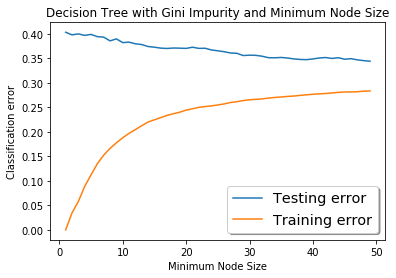

Test error minimized at min_samples_leaf = 49


In [21]:
# Seed the random number generator:
np.random.seed(1)

kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break 

min_samples_leaf = np.arange(1, 50)
clf = tree.DecisionTreeClassifier(criterion='entropy')
# clf.max_depth = 8

train_err, test_err = eval_tree_based_model_min_samples(clf, min_samples_leaf, X_train, 
                                                        y_train, X_test, y_test)

plt.figure()
plt.plot(min_samples_leaf, test_err, label='Testing error')
plt.plot(min_samples_leaf, train_err, label='Training error')
plt.xlabel('Minimum Node Size')
plt.ylabel('Classification error')
plt.title('Decision Tree with Gini Impurity and Minimum Node Size')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.savefig("DT_min_leaf.pdf")
plt.show()

print('Test error minimized at min_samples_leaf = %i' % min_samples_leaf[np.argmin(test_err)])

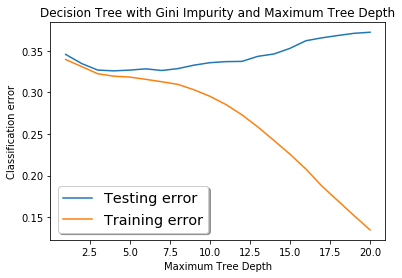

Test error minimized at max_depth = 4


In [22]:
# Seed the random number generator:
np.random.seed(1)

max_depth = np.arange(1, 21)

clf = tree.DecisionTreeClassifier(criterion='entropy')

train_err, test_err = eval_tree_based_model_max_depth(clf, max_depth, X_train, 
                                                        y_train,X_test, y_test)

plt.figure()
plt.plot(max_depth, test_err, label='Testing error')
plt.plot(max_depth, train_err, label='Training error')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Classification error')
plt.title('Decision Tree with Gini Impurity and Maximum Tree Depth')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.savefig("DT_max_depth.pdf")
plt.show()

print('Test error minimized at max_depth = %i' % max_depth[np.argmin(test_err)])

In [137]:
class AdaBoost():
    def __init__(self, n_clfs=100):
        '''
        Initialize the AdaBoost model.

        Inputs:
            n_clfs (default 100): Initializer for self.n_clfs.        
                
        Attributes:
            self.n_clfs: The number of DT weak classifiers.
            self.coefs: A list of the AdaBoost coefficients.
            self.clfs: A list of the DT weak classifiers, initialized as empty.
        '''
        self.n_clfs = n_clfs
        self.coefs = []
        self.clfs = []

    def fit(self, X, Y, n_nodes=4):
        '''
        Fit the AdaBoost model. Note that since we are implementing this method in a class, rather
        than having a bunch of inputs and outputs, you will deal with the attributes of the class.
        (see the __init__() method).
        
        This method should thus train self.n_clfs DT weak classifiers and store them in self.clfs,
        with their coefficients in self.coefs.

        Inputs:
            X: A (N, D) shaped numpy array containing the data points.
            Y: A (N, ) shaped numpy array containing the (float) labels of the data points.
               (Even though the labels are ints, we treat them as floats.)
            n_nodes: The max number of nodes that the DT weak classifiers are allowed to have.
            
        Outputs:
            A (N, T) shaped numpy array, where T is the number of iterations / DT weak classifiers,
            such that the t^th column contains D_{t+1} (the dataset weights at iteration t+1).
        '''
        A = np.zeros((self.n_clfs+1,len(Y)))
        A[0,:] = 1/len(Y)*np.ones(len(Y))

        for i in range(self.n_clfs):
            clf = DecisionTreeRegressor(max_leaf_nodes=n_nodes)
            clf.fit(X,Y,sample_weight=A[i,:]) 
            self.clfs.append(clf)
            Y_p = clf.predict(X)
            L = (Y_p*Y<=0)
            eps = np.sum(A[i,:]*L)
            a = 1/2*np.log((1-eps)/eps)
            self.coefs.append(a)
            A[i+1,:] = A[i,:]*np.exp(-a*Y*Y_p)
            A[i+1,:] = A[i+1,:] / np.sum(A[i+1,:])
        return A
    
    def predict(self, X):
        '''
        Predict on the given dataset.

        Inputs:
            X: A (N, D) shaped numpy array containing the data points.
            
        Outputs:
            A (N, ) shaped numpy array containing the (float) labels of the data points.
            (Even though the labels are ints, we treat them as floats.)
        '''
        # Initialize predictions.
        Y_pred = np.zeros(len(X))
        
        # Add predictions from each DT weak classifier.
        for i, clf in enumerate(self.clfs):
            Y_curr = self.coefs[i] * clf.predict(X)
            Y_pred += Y_curr

        # Return the sign of the predictions.
        return np.sign(Y_pred)

    def loss(self, X, Y):
        '''
        Calculate the classification loss.

        Inputs:
            X: A (N, D) shaped numpy array containing the data points.
            Y: A (N, ) shaped numpy array containing the (float) labels of the data points.
               (Even though the labels are ints, we treat them as floats.)
            
        Outputs:
            The classification loss.
        '''
        # Calculate the points where the predictions and the ground truths don't match.
        Y_pred = self.predict(X)
        misclassified = np.where(Y_pred != Y)[0]

        # Return the fraction of such points.
        return float(len(misclassified)) / len(X)

In [180]:
n_clfs = 100

model = AdaBoost(n_clfs=n_clfs)
D = model.fit(X_train, y_train)

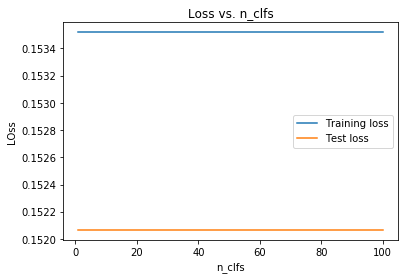

In [181]:
Y_train_pred = np.zeros((1,len(y_train)))
Y_test_pred = np.zeros((1,len(y_test)))
losses_train = []
losses_test = []

# For each added classifier, store the new training and test losses.
for i, clf in enumerate(model.clfs):

    Y_train_pred += model.coefs[i] * clf.predict(X_train)
    Y_test_pred += model.coefs[i] * clf.predict(X_test)

    losses_train.append(len(np.where(np.sign(Y_train_pred) != y_train)[0]) / len(Y_train_pred[0]))
    losses_test.append(len(np.where(np.sign(Y_test_pred) != y_test)[0]) / len(Y_test_pred[0]))

# Plot the losses across n_clfs.
plt.plot(np.arange(1, model.n_clfs + 1), losses_train)
plt.plot(np.arange(1, model.n_clfs + 1), losses_test)
plt.title('Loss vs. n_clfs')
plt.legend(['Training loss', 'Test loss'])
plt.xlabel('n_clfs')
plt.ylabel('LOss')
plt.show()